# 1. BTSP learning rule

In [181]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12,
                 'axes.spines.right': False,
                 'axes.spines.top': False,
                 'axes.linewidth':1.2,
                 'xtick.major.size': 6,
                 'xtick.major.width': 1.2,
                 'ytick.major.size': 6,
                 'ytick.major.width': 1.2,
                 'legend.frameon': False,
                 'legend.handletextpad': 0.1,
                 'figure.figsize': [10.0, 3.0],
                 'svg.fonttype': 'none',
                 'text.usetex': False})

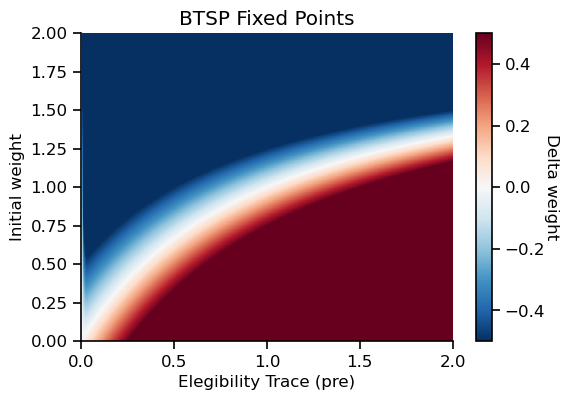

In [182]:
# Plot BTSP weight update function 

def get_scaled_rectified_sigmoid(th=0.01, peak=0.02, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    sigmoid_func = lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (np.clip(xi, x[0], x[-1]) - th))) - start_val) + ylim[0]
    return sigmoid_func

sigmoid = get_scaled_rectified_sigmoid()

def btsp(ET, IS, W, Wmax):
    dW = (Wmax - W)*ET*IS - W * sigmoid(ET * IS)
#     dW = IS*( (Wmax-W)*ET - W*sigmoid(ET) )
    return dW

learning_rate = 0.25
input_peak_rate = 2.0
max_weight_scale = 2.

pre = np.linspace(0., input_peak_rate, 1000)
w0 = np.linspace(0., max_weight_scale, 1000)
pre_mesh, w0_mesh = np.meshgrid(pre, w0)

plt.figure(figsize=[6,4])
plt.pcolormesh(pre_mesh, w0_mesh,
               btsp(pre_mesh, IS=1., W=w0_mesh, Wmax=max_weight_scale),
               cmap='RdBu_r', shading='nearest',
               vmin=-max_weight_scale * learning_rate, vmax=max_weight_scale * learning_rate)
plt.xlabel('Elegibility Trace (pre)')
plt.ylabel('Initial weight')
cbar = plt.colorbar()
cbar.set_label('Delta weight', rotation=-90., labelpad=10)
plt.title('BTSP Fixed Points')
plt.show()

# 2. BTSP simulation

In [183]:
# Run simulation of place cell with uniform equal weights

# Simulation runtime parameters
dt = 1.  # time step (ms)
T = 6000   # simulation time (ms)
time = np.arange(0., T, dt)

# def btsp(ET_IS, W, Wmax):
#     k_dep = 20
#     dW = (Wmax - W)*ET_IS - k_dep*W*sigmoid(ET_IS)
#     return dW

def btsp(ET, IS, W, Wmax):
    k_dep = 0.15
    dW = (Wmax - W)*ET*IS - k_dep*W*sigmoid(ET * IS)
    return dW

def run_simulation(num_synapses, w):
    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 200 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    E_cell = -70
    E_syn = 70
    syn_tau = 50 # (ms)
    ET_tau = 500 / dt # (ms)
    IS_tau = 600 / dt # (ms)
    Wmax = 3.
    lr = 0.01

    plateau_time = np.round(3000 /dt) # (ms)
    first_stim_time = 100 # (ms)
    last_stim_time = T - first_stim_time
    stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    
    # Initialize simulation variables
    simulation_results = {}
    weights = np.ones([len(time),num_synapses]) * w
    V = np.ones(len(time)) * E_cell
    I = np.zeros([len(time),num_synapses])
    ET = np.zeros([len(time),num_synapses]) #presynaptic elegibility traces
    IS = np.zeros(len(time)) # postsynaptic instructive signal (plateau)
    
    for t in range(len(time)): 
        if t in stim_timesteps:
            active_synapse_ids = np.where(stim_timesteps==t)[0]
            ET[t,active_synapse_ids] += 1
            I[t,active_synapse_ids] = np.sum(weights[t,active_synapse_ids] * E_syn *1e-3)
            
        if t == plateau_time:
            IS[t] += 1

        I_total = np.sum(I[t])
            
        if t<len(time)-1: #don't update at the last timestep
            dVdt = ((E_cell-V[t]) + I_total*R) * (1/cell_tau) 
            V[t+1] = V[t] + dVdt*dt

            dIdt = -I[t] / syn_tau
            I[t+1] = I[t] + dIdt*dt
        
            dETdt = -ET[t] / ET_tau
            ET[t+1] = ET[t] + dETdt*dt
            
            dISdt = -IS[t] / IS_tau
            IS[t+1] = IS[t] + dISdt*dt

            dW = btsp(ET[t], IS[t], weights[t], Wmax)
            weights[t+1] = weights[t] + lr*dW
          
#     ET_IS = np.dot(IS,ET)  
#     w = weights[0]
#     dW = btsp(ET_IS, w, Wmax)
#     final_weights = w + lr*dW*0.1
#     weights[-1] = final_weights

    simulation_results['V'] = V
    simulation_results['I'] = I
    simulation_results['el_traces'] = ET
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['IS'] = IS
    simulation_results['W'] = weights
    # simulation_results['W'] = (weights, final_weights)

    return simulation_results
    
num_synapses = 40
weights = np.ones(num_synapses) * 0.5
simulation_results = run_simulation(num_synapses, weights)

new_weights = simulation_results['W'][-1]
simulation_results2 = run_simulation(num_synapses, new_weights)

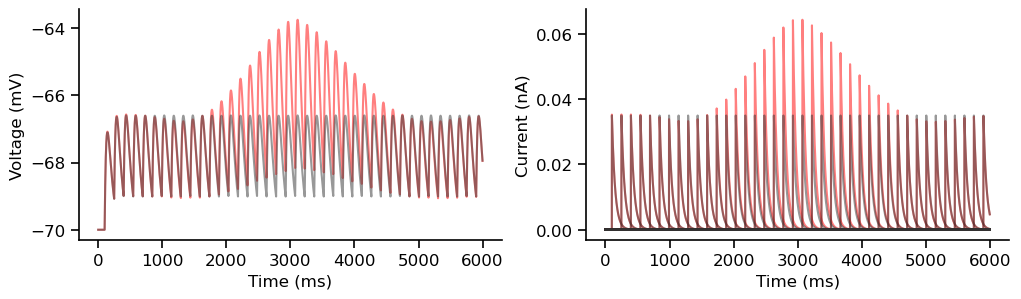

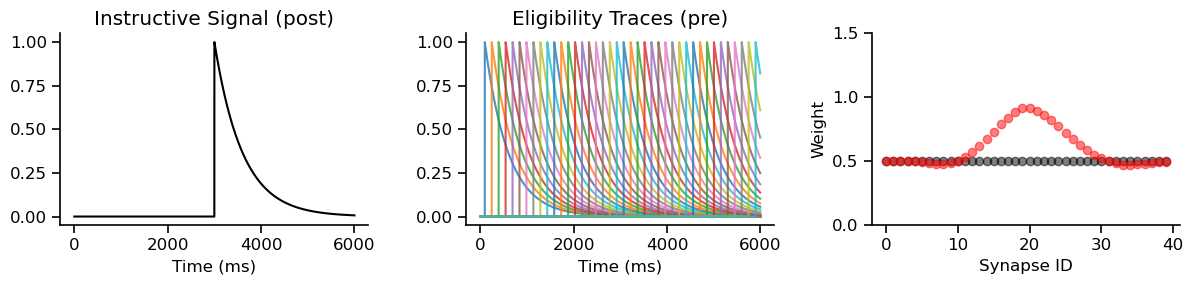

In [184]:
# Plot simulation results 

fig,ax = plt.subplots(1,2,figsize=(12,3))
line_color = [0.2,0.2,0.2]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'el_traces':'Eligibility Traces (pre)',
         'IS': 'Instructive Signal (post)', 'W': 'Weight'}

plot_nr = (0)
ax[plot_nr].plot(time, simulation_results2['V'], c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])
ax[plot_nr].plot(time, simulation_results['V'], color=line_color, alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results2['I'], c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
ax[plot_nr].plot(time, simulation_results['I'], color=line_color, alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])


fig,ax = plt.subplots(1,3,figsize=(12,3))

plot_nr = (0)
ax[plot_nr].plot(time, simulation_results['IS'], c='k')
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results['el_traces'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_title(titles['el_traces'])

plot_nr = (2)
ax[plot_nr].scatter(np.arange(num_synapses), weights, c='k', alpha=0.5)
ax[plot_nr].scatter(np.arange(num_synapses), new_weights, c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,1.5])

plt.tight_layout()
# plt.subplots_adjust(top=0.8)
plt.show()

# <font color='blue'> Emulating BTSP with neuromorphic hardware </font>

In [185]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt):
        self.dt = dt
        self.g = 0
        self.g_history = []
        self.controlV = 0
        self.controlV_history = []
        
    def time_step(self, num_timesteps=1):
        for t in range(num_timesteps):
            self.g_history.append(self.g)
            self.controlV_history.append(self.controlV)

            g_eq = self.transfer_func(self.controlV) 
            dgdt = (g_eq - self.g) / self.tau(self.controlV) * 0.1
            self.g += dgdt * self.dt
            # self.g = np.max([self.g, 0.])
        
    def transfer_func(self, controlV):
        '''
        Function to convert between control_v and resistance
        '''
        slope = 1
        g = slope * controlV
        return g
    
    def inv_transfer_func(self, g):
        slope = 1
        controlV = g / slope
        return controlV
        
    def tau(self, controlV):
        tau = (1 + 0.4/(controlV + 1e-4)) * 0.1
        return tau
    
    def compute_controlV(self, tau):
        controlV = (0.4*0.1 / (tau-0.1)) - 1e-4
        return controlV
    

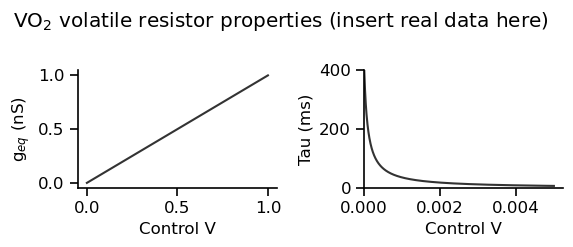

Pulse control V = 1.0
Baseline control V (to set the decay tau) = 3.337779259753253e-05
Tau = 300 ms


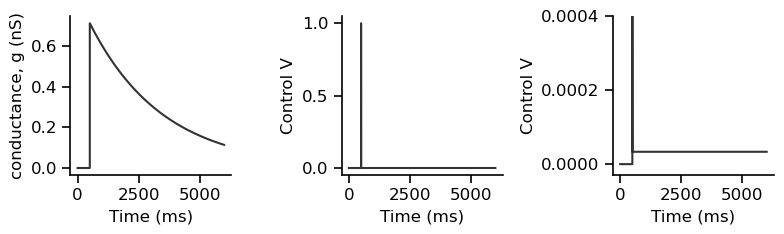

In [186]:
# Plot properties 
g_volatile = Volatile_Resistor(dt)

fig,ax = plt.subplots(1,2,figsize=[6,2.5])

control_v = np.linspace(0,1,100)
g_eq = g_volatile.transfer_func(control_v)
ax[0].plot(control_v,g_eq, c=line_color)
ax[0].set_xlabel('Control V')
ax[0].set_ylabel('g$_{eq}$ (nS)')

control_v = np.linspace(0,0.005,1000)
ax[1].plot(control_v,g_volatile.tau(control_v),c=line_color)
ax[1].set_xlabel('Control V')
ax[1].set_ylabel('Tau (ms)')
ax[1].set_ylim([0,400])
ax[1].set_xlim(left=0)

plt.suptitle('VO$_{2}$ volatile resistor properties (insert real data here)')
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,3,figsize=[8,2.5])
baselineV = g_volatile.compute_controlV(300)
pulseV = 1.
print(f"Pulse control V = {pulseV}")
print(f"Baseline control V (to set the decay tau) = {baselineV}")
print(f"Tau = {round(g_volatile.tau(baselineV))} ms")

for t in time:
    if t==500:
        g_volatile.controlV = pulseV   
    if t>500:
        g_volatile.controlV = baselineV
    g_volatile.time_step()
    
ax[0].plot(time, g_volatile.g_history,c=line_color)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('conductance, g (nS)')

ax[1].plot(time, g_volatile.controlV_history,c=line_color)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Control V')

ax[2].plot(time, g_volatile.controlV_history,c=line_color)
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Control V')
ax[2].set_ylim([-3*1e-5,4e-4])

plt.tight_layout()
plt.show()

In [187]:
class Synapse(Volatile_Resistor):
    def __init__(self, dt):
        self.ET = Volatile_Resistor(dt) # elegibility trace
        self.channel = Volatile_Resistor(dt)

    def time_step(self, num_timesteps=1):
        self.ET.time_step(num_timesteps)
        self.channel.time_step(num_timesteps)

In [188]:
# Run simulation of place cell with uniform equal weights

# Simulation runtime parameters
dt = 1.  # time step (ms)
T = 6000   # simulation time (ms)
time = np.arange(0., T, dt)

def btsp(ET, IS, W, Wmax):
    k_dep = 0.3
    dW = (Wmax - W)*ET*IS - k_dep*W*sigmoid(ET * IS)
    return dW

def run_simulation(num_synapses, w, plateau_time=3000):
    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 200 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    V_cell = 0
    V_probe = 70
    syn_tau = 5 # (ms)
    ET_tau = 30  # (ms)
    IS_tau = 50  # (ms)
    Wmax = 2.
    lr = 0.003

    baselineV = 0.1
    AMPA_synapse = Volatile_Resistor(dt)
    baselineV_syn = AMPA_synapse.compute_controlV(syn_tau)
    baselineV_ET = AMPA_synapse.compute_controlV(ET_tau)
    baselineV_IS = AMPA_synapse.compute_controlV(IS_tau)
    controlV_dur = 10

    plateau_time = np.round(plateau_time /dt) # (ms)
    first_stim_time = 100 # (ms)
    last_stim_time = T - first_stim_time

    stim_timesteps = np.linspace(first_stim_time, last_stim_time, num_synapses) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    stim_timesteps_extended = np.repeat(stim_timesteps,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps))
    
    # Initialize simulation variables
    synapse_list = []
    for i in range(num_synapses):
        synapse_list.append(Synapse(dt))
    IS = Volatile_Resistor(dt)

    simulation_results = {}
    weights = np.ones([len(time),num_synapses]) * w
    V = np.ones(len(time)) * V_cell
    I = np.zeros([len(time),num_synapses])
    
    for t in range(len(time)): 
        if t not in stim_timesteps_extended:
            for i in range(num_synapses):
#                 if t > stim_timesteps[i]: # if synapse has been activated
                synapse_list[i].ET.controlV = baselineV_ET
                synapse_list[i].channel.controlV = baselineV_syn
        IS.controlV = baselineV_IS

        if t in stim_timesteps:
            active_synapse_ids = np.where(stim_timesteps==t)[0]

            for i in active_synapse_ids:
                synapse = synapse_list[i]
                synapse.ET.controlV = synapse.inv_transfer_func(synapse.ET.g + 1.)
                if i==30:
                    print(weights[t,i],synapse.channel.g)
                    
                synapse.channel.controlV = synapse.inv_transfer_func(synapse.channel.g + weights[t,i])

        if t >= plateau_time and t < plateau_time + controlV_dur:
            IS.g = IS.inv_transfer_func(IS.g + 1.)

        for i in range(num_synapses):
            I[t,i] = synapse_list[i].channel.g * V_probe *1e-3
        
        I_total = np.sum(I[t])
            
        if t<len(time)-1: #don't update at the last timestep
            dVdt = ((V_cell-V[t]) + I_total*R) * (1/cell_tau) 
            V[t+1] = V[t] + dVdt*dt

            ET = np.array([synapse_list[i].ET.g for i in range(num_synapses)])
            dW = btsp(ET, IS.g, weights[t], Wmax)
            weights[t+1] = weights[t] + lr*dW


        for i in range(num_synapses):
            synapse_list[i].time_step()
        IS.time_step()



    control_v = []
    ET = []
    for i in range(num_synapses):
        control_v.append(synapse_list[i].channel.controlV_history)
        ET.append(synapse_list[i].ET.g_history)

    simulation_results['control_v'] = np.array(control_v).T
    simulation_results['V'] = V
    simulation_results['I'] = I
    simulation_results['el_traces'] = np.array(ET).T
    simulation_results['stim_times'] = stim_timesteps
    simulation_results['IS'] = IS.g_history
    simulation_results['W'] = weights

    return simulation_results
    
num_synapses = 40
weights = np.ones(num_synapses) * 0.5
simulation_results = run_simulation(num_synapses, weights)

new_weights = simulation_results['W'][-1]
simulation_results2 = run_simulation(num_synapses, new_weights)

0.4369296043889033 0.008063265306122409
0.40305614941927437 0.008063265306122409


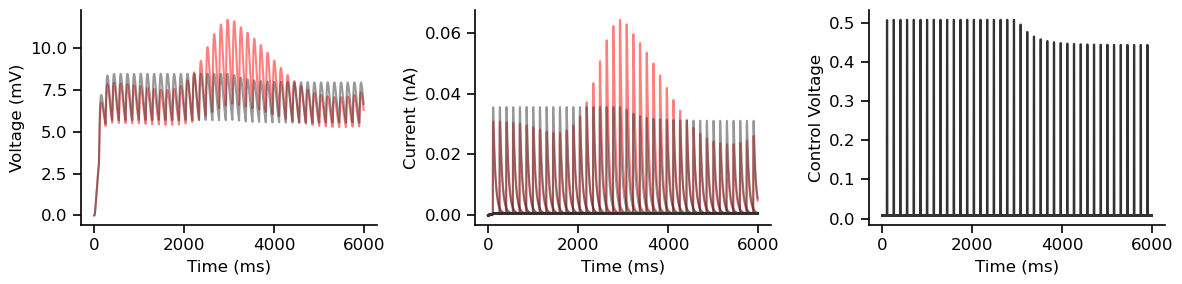

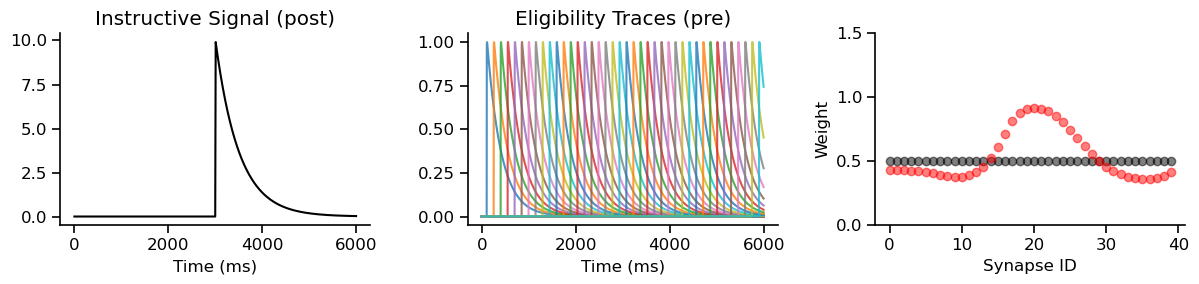

In [178]:
# Plot simulation results 

fig,ax = plt.subplots(1,3,figsize=(12,3))
line_color = [0.2,0.2,0.2]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'el_traces':'Eligibility Traces (pre)',
         'IS': 'Instructive Signal (post)', 'W': 'Weight', 'control_v': 'Control Voltage'}

plot_nr = (0)
ax[plot_nr].plot(time, simulation_results2['V'], c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])
ax[plot_nr].plot(time, simulation_results['V'], color=line_color, alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results2['I'], c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
ax[plot_nr].plot(time, simulation_results['I'], color=line_color, alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])

plot_nr = (2)
ax[plot_nr].plot(time, simulation_results['control_v'], color=line_color)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['control_v'])
plt.tight_layout()


fig,ax = plt.subplots(1,3,figsize=(12,3))
plot_nr = (0)
ax[plot_nr].plot(time, simulation_results['IS'], c='k')
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results['el_traces'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_title(titles['el_traces'])

plot_nr = (2)
ax[plot_nr].scatter(np.arange(num_synapses), weights, c='k', alpha=0.5)
ax[plot_nr].scatter(np.arange(num_synapses), new_weights, c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,1.5])

plt.tight_layout()
plt.show()

In [179]:
num_synapses = 40
weights = simulation_results2['W'][-1]
simulation_results = run_simulation(num_synapses, weights, plateau_time = 1000)

new_weights = simulation_results['W'][-1]
simulation_results2 = run_simulation(num_synapses, new_weights)

0.3921652894446871 0.008063265306122409
0.3402612953856656 0.008063265306122409


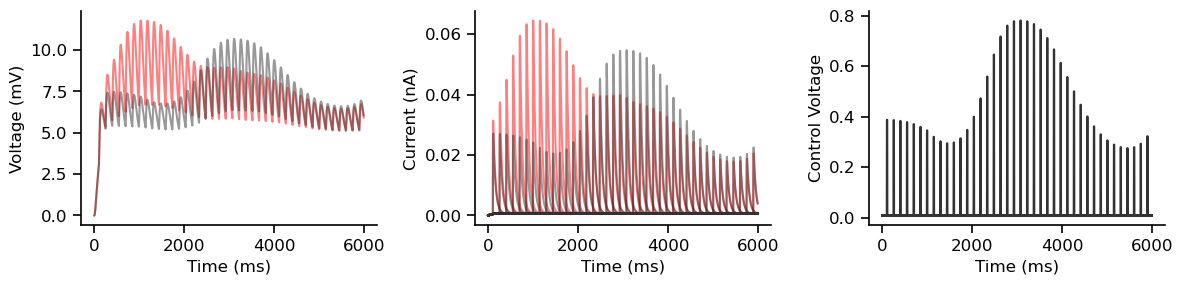

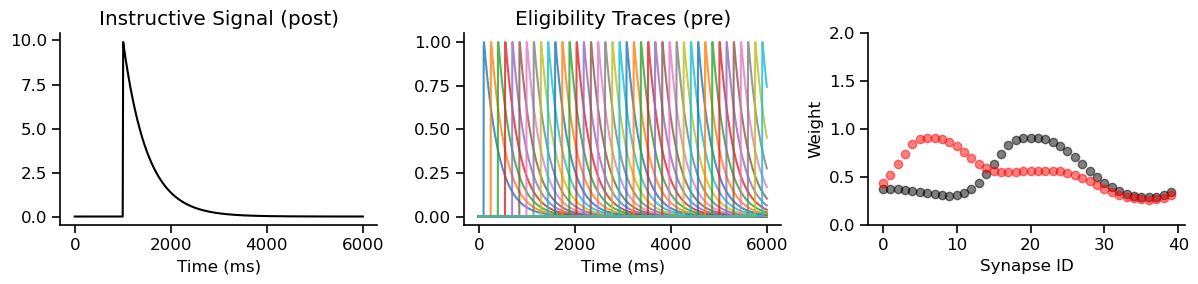

In [180]:
# Plot simulation results 

fig,ax = plt.subplots(1,3,figsize=(12,3))
line_color = [0.2,0.2,0.2]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'el_traces':'Eligibility Traces (pre)',
         'IS': 'Instructive Signal (post)', 'W': 'Weight', 'control_v': 'Control Voltage'}

plot_nr = (0)
ax[plot_nr].plot(time, simulation_results2['V'], c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])
ax[plot_nr].plot(time, simulation_results['V'], color=line_color, alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results2['I'], c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
ax[plot_nr].plot(time, simulation_results['I'], color=line_color, alpha=0.5)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])

plot_nr = (2)
ax[plot_nr].plot(time, simulation_results['control_v'], color=line_color)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['control_v'])
plt.tight_layout()


fig,ax = plt.subplots(1,3,figsize=(12,3))
plot_nr = (0)
ax[plot_nr].plot(time, simulation_results['IS'], c='k')
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_title(titles['IS'])

plot_nr = (1)
ax[plot_nr].plot(time, simulation_results['el_traces'], alpha=0.8)
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_title(titles['el_traces'])

plot_nr = (2)
ax[plot_nr].scatter(np.arange(num_synapses), weights, c='k', alpha=0.5)
ax[plot_nr].scatter(np.arange(num_synapses), new_weights, c='r', alpha=0.5)
ax[plot_nr].set_xlabel('Synapse ID')
ax[plot_nr].set_ylabel(titles['W'])
ax[plot_nr].set_ylim([0,2])

plt.tight_layout()
plt.show()